In [3]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import matplotlib
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [4]:
adata = sc.read_10x_mtx('../data/rawData/JA23314/cellranger/JA23314/outs/count/filtered_feature_bc_matrix', cache=True)

/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [5]:
adata.write_h5ad('../data/h5ads/jostner-raw.h5ad')

# Quality Control

In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 17605 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categor

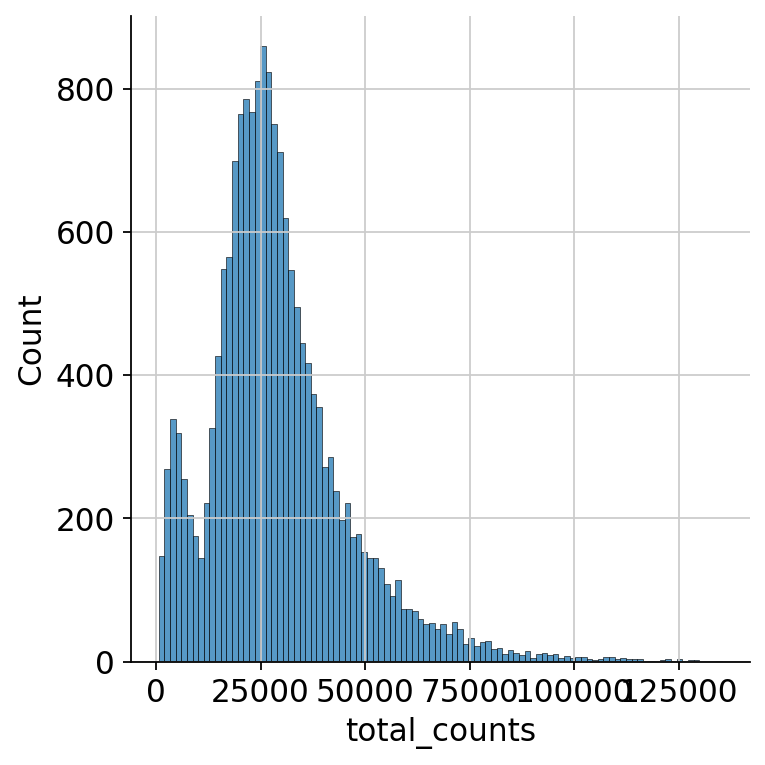

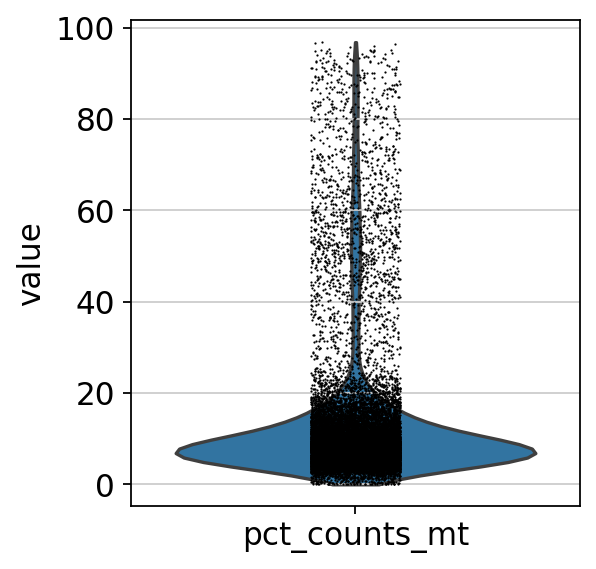

/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


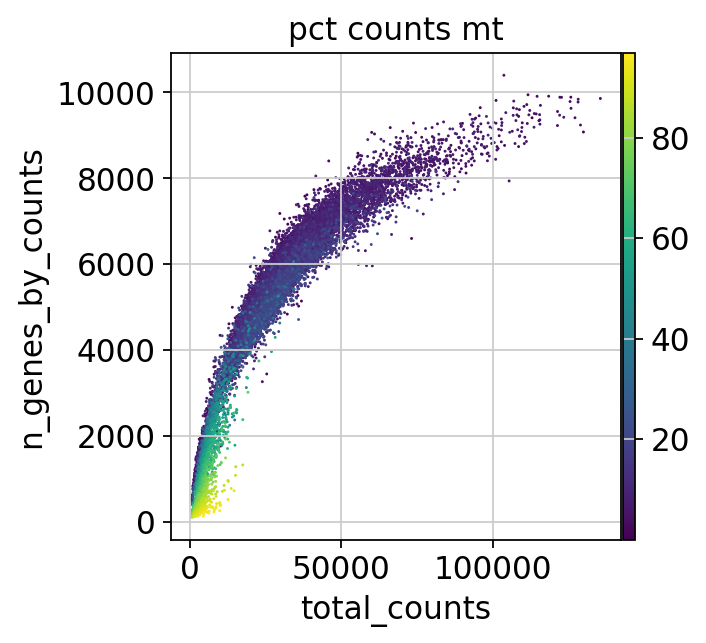

In [7]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [9]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    15534
True      2071
Name: count, dtype: int64

In [10]:
# Here I stick to a mitochondrial fraction of < 20%
# This is much higher than the single cell tutorial
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 20
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    15150
True      2455
Name: count, dtype: int64

In [11]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 17605


/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Number of cells after filtering of low quality cells: 14950


/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/scanpy/plotting/_utils.py:714: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


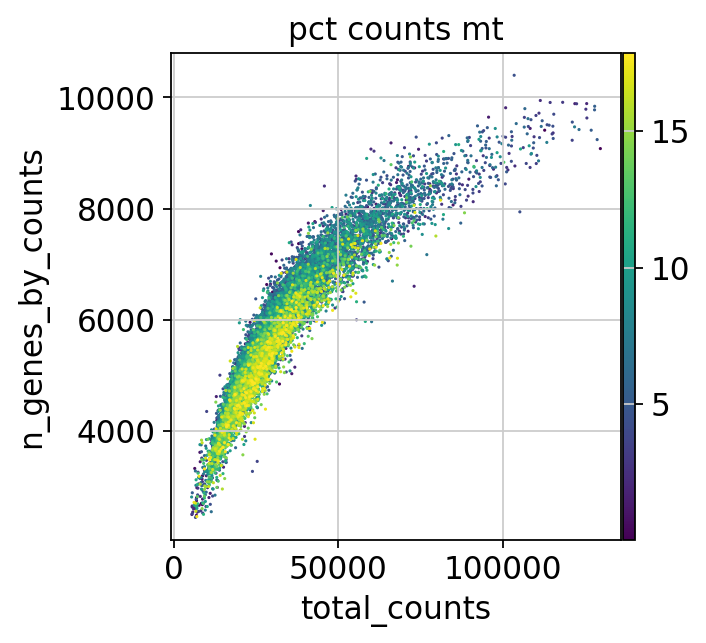

In [12]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Ambient RNA Correction with `SoupX`

In [14]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro


# rcb.logger.setLevel(logging.ERROR)
# ro.pandas2ri.activate()
# anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [15]:
%%R
library(SoupX)

In [16]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

del adata_pp

cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this 

In [17]:
adata_raw = sc.read_10x_h5('../data/rawData/JA23314/cellranger/JA23314/outs/count/filtered_feature_bc_matrix.h5')
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T
del adata_raw


/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/stor/work/Brock/Tyler/optimalSeparation/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [33]:
xample = 'hi'

In [50]:
data_dense = data.todense()

data_tod_dense = data_tod.todense()


In [52]:
%%R -i data_dense -i data_tod_dense -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

R[write to console]: Error in `rownames<-`(`*tmp*`, value = c("MIR1302-2HG", "FAM138A", "OR4F5",  : 
  attempt to set 'rownames' on an object with no dimensions




Error in `rownames<-`(`*tmp*`, value = c("MIR1302-2HG", "FAM138A", "OR4F5",  : 
  attempt to set 'rownames' on an object with no dimensions


RInterpreterError: Failed to parse and evaluate line '\n# specify row and column names of data\nrownames(data) = genes\ncolnames(data) = cells\n# ensure correct sparse format for table of counts and table of droplets\ndata <- as(data, "sparseMatrix")\ndata_tod <- as(data_tod, "sparseMatrix")\n\n# Generate SoupChannel Object for SoupX \nsc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)\n\n# Add extra meta data to the SoupChannel object\nsoupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))\nsc = setSoupProfile(sc, soupProf)\n# Set cluster information in SoupChannel\nsc = setClusters(sc, soupx_groups)\n\n# Estimate contamination fraction\nsc  = autoEstCont(sc, doPlot=FALSE)\n# Infer corrected table of counts and rount to integer\nout = adjustCounts(sc, roundToInt = TRUE)\n'.
R error message: 'Error in `rownames<-`(`*tmp*`, value = c("MIR1302-2HG", "FAM138A", "OR4F5",  : \n  attempt to set \'rownames\' on an object with no dimensions'

In [ ]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.to_h5ad('../data/h5ads/jostner-ambient.h5ad')